In [166]:
#Importing needed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

In [167]:
#extract

def fx_extract_performance(v_year):
    df_performance = pd.read_csv('result_campus.csv')
    rename_dict = {'Campus': 'campus_id' , 'Year' : 'year', 'Pass_rate' : 'pct_pass'}
    df_performance.rename(columns=rename_dict, inplace=True)
    return df_performance

def fx_extract_student_teacher(v_year):
    v_filename = 'CAMPPROF_'+ str(v_year) + '.csv'
    df_student_teacher = pd.read_csv(v_filename)
    rename_dict = {"CPSTTOSA": "avg_salary", "CAMPUS": "campus_id","CPETECOC": "ed_count", "CPETALLC" : 'student_count' }
    df_student_teacher.rename(columns=rename_dict, inplace=True)
    df_student_teacher['year'] = [v_year for i,r in df_student_teacher.iterrows() ]
    df_student_teacher =df_student_teacher.loc[:,['campus_id',  'ed_count', 'avg_salary', 'year','student_count']]
    return df_student_teacher

def fx_extract_community():
    df_community = pd.read_csv('Community.csv')
    return df_community



In [168]:
# #transform

def transform_merge(df_performance,df_student_teacher,df_community):
    df_community_performance = pd.merge(df_community,df_performance, on =['campus_id'], how='inner')
    df_community_complete = pd.merge(df_community_performance,df_student_teacher,on =['campus_id','year'], how='inner')
    #df_community_complete['pct_pass'] = [(100*r['pass_count']/r['student_count']) for i, r in df_community_complete.iterrows()]
    df_community_complete['pct_ed'] = [(100*r['ed_count']/r['student_count']) for i, r in df_community_complete.iterrows()]
    df_community_complete['perf_value'] = [r.pct_ed + r.pct_pass for i,r in df_community_complete.iterrows() ]
    DataFrame1_1 = df_community_complete.sort_values(['perf_value'], ascending=False)

    DataFrame1_1.reset_index(inplace=True)
    DataFrame1_1['perf_value_rank'] = [i for i,r in DataFrame1_1.iterrows() ]
    student_sum = DataFrame1_1['student_count'].sum() 
    DataFrame1_1['student_quartile_value'] = [r['student_count']/student_sum for i,r in DataFrame1_1.iterrows() ]
    DataFrame1_2 = DataFrame1_1.sort_values(['student_quartile_value'], ascending=False)

    DataFrame1_2.reset_index(inplace=True)
    DataFrame1_2['student_quartile_value_rank'] = [i for i,r in DataFrame1_2.iterrows() ]
    student_max_rank = DataFrame1_2['student_quartile_value_rank'].max() 
    DataFrame1_2['student_quartile'] = [1 if r['student_quartile_value_rank']/student_max_rank < .25 else
                                        2 if r['student_quartile_value_rank']/student_max_rank < .50 else
                                        3 if r['student_quartile_value_rank']/student_max_rank < .75 else
                                        4 if r['student_quartile_value_rank']/student_max_rank < 1.00 else -1
                                        for i,r in DataFrame1_2.iterrows() ]

#     DataFrame1_2.reset_index()
    return DataFrame1_2
def fx_economical_disadvantage(df_performance,df_student_teacher,df_community):
    df_community_complete= transform_merge(df_performance,df_student_teacher,df_community)
    df_return = df_community_complete.loc[:,['campus_name',  'pct_ed', 'pct_pass' , 'student_quartile' ,'perf_value_rank', 'community', 'year']]
    df_return.drop_duplicates()
    df_return = df_return.dropna(how='any')
    return df_return
def fx_salary(df_performance,df_student_teacher,df_community):
    df_community_complete= transform_merge(df_performance,df_student_teacher,df_community)
    df_return = df_community_complete.loc[:,['campus_name',  'avg_salary', 'pct_pass' , 'student_quartile' ,'perf_value_rank', 'community', 'year']]
    df_return.drop_duplicates()
    df_return = df_return.dropna(how='any')
    return df_return

def fx_community(df_performance,df_community):
    df_community_performance = pd.merge(df_community,df_performance,on = 'campus_id', how='inner')
    #df_community_performance['pct_pass'] = [(100*r['pass_count']/r['student_countxx']) for i, r in df_community_performance.iterrows()]
    unique_community_type = pd.Series(df_community_performance["community"]).unique()
    df_community = pd.DataFrame(unique_community_type,columns=['community'])
    df_community['median_pass'] = [df_community_performance.loc[(df_community_performance['community']==x) , 'pct_pass'].median()  for x in df_community["community"]]
    df_community.drop_duplicates()
    df_community = df_community.dropna(how='any')
    return df_community


In [169]:
# plot function 
def fx_bar_plot(DataFrameB, legend_dict):
    x = DataFrameB['x_data']   
    y = DataFrameB['y_data']   
    rgb_values = sns.color_palette("Set2", len(DataFrameB['x_data']))
    fig, ax = plt.subplots()
    fig.suptitle(legend_dict['title'], fontsize=15)
    fig.tight_layout() # remove space between header and title
    fig.subplots_adjust(top=.93) # adjust so title is just above chart
    fig.set_size_inches(10, 6)
    ax.set_ylim(65, 85, .5)
    #ax.bar(x, y, .75, color = rgb_values, linewidth=.5)
    bar_columns = ax.bar(x, y, .75, color = rgb_values, linewidth=.5)
    for column in bar_columns:
        height = column.get_height()
        # Attach a text label above each bar displaying its height
        ax.text(column.get_x() + column.get_width()/2, height,
                '%d' % int(height),
                ha='center', va='bottom')
    ax.set_ylabel(legend_dict['ylabel'], fontsize=12)
    ax.xaxis.grid(color='white', linestyle='solid', linewidth=1)
    ax.yaxis.grid(color='white', linestyle='solid', linewidth=1)
    ax.set_axisbelow(True) # show plots on top of grid lines
    ax.set_facecolor('lightgray')
    ax.tick_params('y', length=0, labelsize=13) # hide tick marks still show lables
    ax.tick_params('x', rotation=90.0, length=0, labelsize=15) # hide tick marks still show lables
    sns.despine(left=True, bottom=True, right=True) # remove border around chart
    #fig.savefig(legend_dict['title'], bbox_inches="tight")
    fig.savefig(legend_dict['title'], bbox_inches = 'tight')
    plt.show() 

In [170]:
v_interested_year = 2016
df_performance = fx_extract_performance(v_interested_year)
df_student_teacher = fx_extract_student_teacher(v_interested_year)
df_community = fx_extract_community()
#transform
DataFrame1 = fx_economical_disadvantage(df_performance,df_student_teacher,df_community)
DataFrame2 = fx_salary(df_performance,df_student_teacher,df_community)

DataFrame1.head()

,campus_name,pct_ed,pct_pass,student_quartile,perf_value_rank,community,year
0,TEXAS CONNECTIONS ACADEMY AT HOUST,39.091265,77,1,6216,Marjor Urban,2016
1,ALLEN H S,13.620072,91,1,7099,Other CC Suburban,2016
2,SKYLINE H S,83.725865,67,1,1907,Marjor Urban,2016
3,NORTH SHORE SENIOR HIGH,71.228146,75,1,2467,Major Suburban,2016
4,LEWISVILLE H S,55.768791,81,1,3682,Major Suburban,2016


In [171]:
# legend_dict = {'title' : str(v_interested_year) + ' Passing Pct vs Community Type',
#                'ylabel' : '% Passing (Median)',
#                'figname' : str(v_interested_year) +' passing_vs_community'
#               }
DataFrameA = DataFrame1.loc[:, ['pct_ed', 'pct_pass', 'student_quartile', 'community' , 'perf_value_rank']]
rename_dict = {'pct_ed': 'x_data', 'pct_pass': 'y_data', 'student_quartile': 'bubble_size',
               'community': 'color_category' }
DataFrameA.rename(columns=rename_dict, inplace=True)
# DataFrameA.to_csv('DataFrameA.csv')
# xx= pd.read_csv('DataFrameA.csv')
# xx
#DataFrameA.loc[(DataFrameA['y_data'] > 100)]
#fx_perf(DataFrameA, legend_dict)

In [172]:
# fx_perf(DataFrameA, legend_dict):
#     eco_dis_1= DataFrameA.x_data
#     performance_1 = ed_1_df.pass_rate
#     quartile_1 = ed_1_df.Quartile

#     eco_dis_2= ed_2_df.CPETECOP
#     performance_2 = ed_2_df.pass_rate
#     quartile_2 = ed_2_df.Quartile

#     eco_dis_3= ed_3_df.CPETECOP
#     performance_3 = ed_3_df.pass_rate
#     quartile_3 = ed_3_df.Quartile

#     eco_dis_4= ed_4_df.CPETECOP
#     performance_4 = ed_4_df.pass_rate
#     quartile_4 = ed_4_df.Quartile

#     x = DataFrameA.x_data
#     y = DataFrameA.y_data

#     plt.scatter(x,
#                y,
#                s=2.5, c=“gold”, linewidths=1, marker=“o”,
#                alpha=0.8, label=“Quartile 1”)

#     # Incorporate the other graph properties
#     plt.title(“Poverty’s Effect on Student Achievement (Q1)“)
#     plt.ylabel(“% Passing STAAR”)
#     plt.xlabel(“% Students on Free/RP Lunch”)
#     plt.grid(True)

#     # Create a legend
#     lgnd = plt.legend(fontsize=“small”, mode=“Expanded”,
#                      numpoints=1, scatterpoints=1,
#                      loc=“best”, title=“Stu Pop Quartile”,
#                      labelspacing=0.5)
#     lgnd.legendHandles[0]._sizes = [10]

#     plt.xlim(0, 100)
#     plt.ylim(0, 100)


#     plt.xticks(np.arange(min(x), max(x)+1, 10))
#     plt.yticks(np.arange(min(x), max(x)+1, 10))


#     # Save Figure
#     plt.savefig(“analysis/eco_dis_perf_Q1.jpg”)

#     # Show plot
#     plt.show()

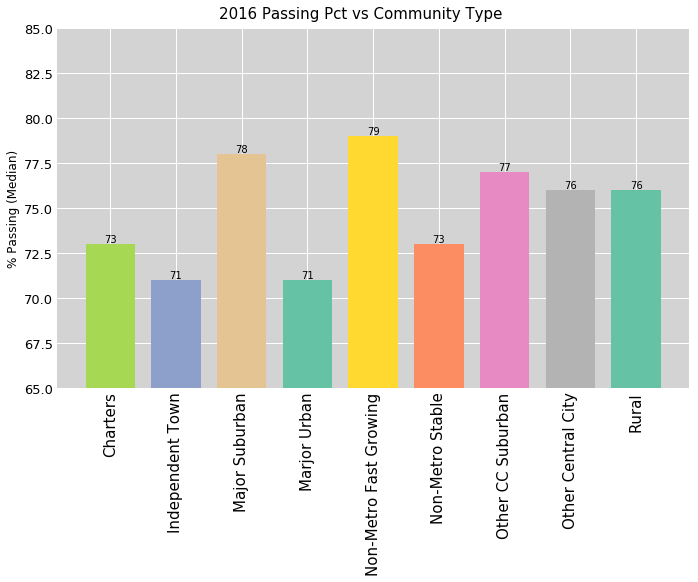

In [173]:

for v_interested_year in [2016]:
    #extract
    df_performance = fx_extract_performance(v_interested_year)
    df_student_teacher = fx_extract_student_teacher(v_interested_year)
    df_community = fx_extract_community()
    #transform
    DataFrame1 = fx_economical_disadvantage(df_performance,df_student_teacher,df_community)
    DataFrame2 = fx_salary(df_performance,df_student_teacher,df_community)
    DataFrame3 = fx_community(df_performance,df_community)
    # bar plot call 
    legend_dict = {'title' : str(v_interested_year) + ' Passing Pct vs Community Type',
                   'ylabel' : '% Passing (Median)',
                   'figname' : str(v_interested_year) +' passing_vs_community'
                  }
    DataFrameB =DataFrame3.loc[:,['community','median_pass']]
    rename_dict = {'community': 'x_data', 'median_pass': 'y_data'}
    DataFrameB.rename(columns=rename_dict, inplace=True)
    fx_bar_plot(DataFrameB, legend_dict)

